# Import Necessary Modules

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image as Image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Flatten, Dense 
from tensorflow.keras.optimizers import Adam

# Load the 'Flower-17' Dataset
Download the Flower 17 dataset from https://www.kaggle.com/datasets/saidakbarp/17-category-flowers

## Create Data Generator Objects

In [2]:
# Create a Data Generator object for training dataset
train_datagen = Image.ImageDataGenerator(rotation_range=20,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         horizontal_flip=True,
                                         rescale=1./255)

# Create a Data Generator object for validation dataset
val_datagen = Image.ImageDataGenerator(rescale=1./255)

## Load the Training & Validation Datasets

In [3]:
batch_size = 32

# Load the training dataset
train_generator = train_datagen.flow_from_directory(
    directory='./Dataset/training/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

# Load the validation dataset
val_generator = val_datagen.flow_from_directory(
    directory='./Dataset/validation/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Store no of images present in training & validation datasets
nb_train_samples = train_generator.samples
nb_val_samples = val_generator.samples

Found 1190 images belonging to 17 classes.
Found 170 images belonging to 17 classes.


# Build a Model Using VGG16

## Prepare a Base Model

In [4]:
# Load the VGG16 model without the top layers
base_model = VGG16(input_shape=(224, 224, 3),
                   include_top=False,
                   weights="imagenet")

# Freeze the base model
base_model.trainable = False
# Print a summary of the base model
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Construct the Head of the Model

In [5]:
# Initialize input of head_model as per the input of base_model
head_model = base_model.input
# Add the base_model & keep our batchnorm layers in inference mode when we unfreeze the base_model
head_model = base_model(head_model, training=False)
# Add a flatten layer which will aid in flattening the input
head_model = Flatten()(head_model)
# Add a dense/FC layer
head_model = Dense(512, activation='relu')(head_model)
# Add a dense/FC layer
head_model = Dense(17, activation="softmax")(head_model)

## Build the Final Model

In [6]:
# Place the constructed head on top of the base model
model = Model(inputs=base_model.input, outputs=head_model)
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
# Print a summary of the base model                                                  
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 17)                8721      
Total params: 27,568,977
Trainable params: 12,854,289
Non-trainable params: 14,714,688
_________________________________________________________________


## Define Callbacks

In [7]:
# Define a callback for saving only the best model during the training
checkpoint = ModelCheckpoint(filepath="./Trained Models/flower17_classifier.h5",
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Define a callback to stop training when validation accuracy has stopped increasing
earlystop = EarlyStopping(monitor='val_accuracy',
                          mode='max',
                          patience=5,
                          restore_best_weights=True,
                          verbose=1)

# Put our callbacks into a list
callbacks = [earlystop, checkpoint]

# Train the Head of the Model

In [8]:
# Train our the head of the model
model.fit(x=train_generator,
          epochs=100,
          callbacks=callbacks,
          steps_per_epoch=nb_train_samples // batch_size,
          validation_data=val_generator,
          validation_steps=nb_val_samples // batch_size)

Epoch 1/100
37/37 [==============================] - 36s 657ms/step - loss: 6.1211 - accuracy: 0.1972 - val_loss: 1.0334 - val_accuracy: 0.7063

Epoch 00001: val_accuracy improved from -inf to 0.70625, saving model to ./Trained Models\flower17_classifier.h5
Epoch 2/100
37/37 [==============================] - 22s 589ms/step - loss: 1.1162 - accuracy: 0.6713 - val_loss: 0.8291 - val_accuracy: 0.7500

Epoch 00002: val_accuracy improved from 0.70625 to 0.75000, saving model to ./Trained Models\flower17_classifier.h5
Epoch 3/100
37/37 [==============================] - 22s 595ms/step - loss: 0.8589 - accuracy: 0.7531 - val_loss: 0.5872 - val_accuracy: 0.8250

Epoch 00003: val_accuracy improved from 0.75000 to 0.82500, saving model to ./Trained Models\flower17_classifier.h5
Epoch 4/100
37/37 [==============================] - 22s 601ms/step - loss: 0.5648 - accuracy: 0.8333 - val_loss: 0.5653 - val_accuracy: 0.8313

Epoch 00004: val_accuracy improved from 0.82500 to 0.83125, saving model to

# Perform Fine-Tuning

In [9]:
# Unfreeze the all the frozen layers in the model
model.trainable = True
# Compile the model again
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])
# Print a summary of the model                                                  
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 17)                8721      
Total params: 27,568,977
Trainable params: 27,568,977
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Fine tune our model and store the training results in a variable
model_train_result = model.fit(x=train_generator,
                               epochs=25,
                               callbacks=callbacks,
                               steps_per_epoch=nb_train_samples // batch_size,
                               validation_data=val_generator,
                               validation_steps=nb_val_samples // batch_size)

Epoch 1/25
37/37 [==============================] - 41s 968ms/step - loss: 0.1921 - accuracy: 0.9432 - val_loss: 0.7559 - val_accuracy: 0.8562

Epoch 00001: val_accuracy did not improve from 0.89375
Epoch 2/25
37/37 [==============================] - 35s 943ms/step - loss: 0.1146 - accuracy: 0.9747 - val_loss: 0.7075 - val_accuracy: 0.8625

Epoch 00002: val_accuracy did not improve from 0.89375
Epoch 3/25
37/37 [==============================] - 36s 950ms/step - loss: 0.1322 - accuracy: 0.9631 - val_loss: 0.4724 - val_accuracy: 0.9000

Epoch 00003: val_accuracy improved from 0.89375 to 0.90000, saving model to ./Trained Models\flower17_classifier.h5
Epoch 4/25
37/37 [==============================] - 36s 952ms/step - loss: 0.0803 - accuracy: 0.9787 - val_loss: 0.5373 - val_accuracy: 0.8938

Epoch 00004: val_accuracy did not improve from 0.90000
Epoch 5/25
37/37 [==============================] - 36s 955ms/step - loss: 0.0630 - accuracy: 0.9785 - val_loss: 0.4559 - val_accuracy: 0.9000


# Evaluate Model's Performance

## Loss & Accuracy Charts

### Loss Chart

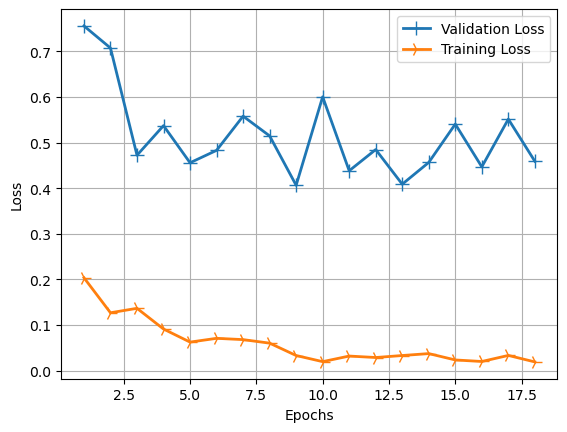

In [11]:
history_dict = model_train_result.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### Accuracy Chart

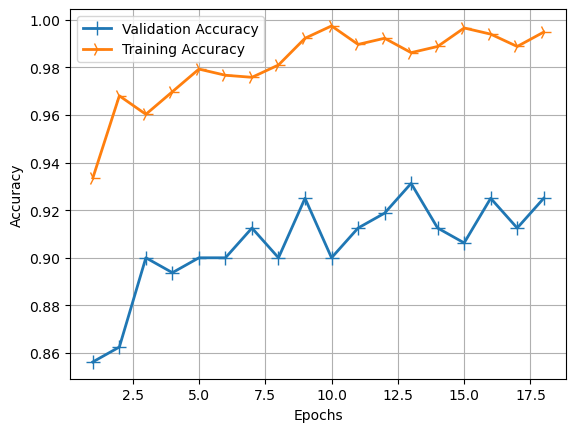

In [12]:
history_dict = model_train_result.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Classification Report for Validation Dataset

In [13]:
# Get model's predictions for each image in val dataset
val_pred = model.predict(val_generator, nb_val_samples // batch_size + 1)
val_pred = np.argmax(val_pred, axis=1)

# Get class names
class_names = val_generator.class_indices
class_names = {v: k for k, v in class_names.items()}
class_names = list(class_names.values())

# Get the classification report generated for val dataset
print(classification_report(y_true=val_generator.classes,
                            y_pred=val_pred, target_names=class_names))

              precision    recall  f1-score   support

    bluebell       1.00      0.70      0.82        10
   buttercup       1.00      1.00      1.00        10
  colts_foot       0.91      1.00      0.95        10
     cowslip       1.00      0.50      0.67        10
      crocus       0.77      1.00      0.87        10
    daffodil       0.91      1.00      0.95        10
       daisy       1.00      1.00      1.00        10
   dandelion       1.00      0.90      0.95        10
  fritillary       1.00      1.00      1.00        10
        iris       0.67      1.00      0.80        10
 lily_valley       1.00      0.80      0.89        10
       pansy       1.00      1.00      1.00        10
    snowdrop       1.00      1.00      1.00        10
   sunflower       0.91      1.00      0.95        10
   tigerlily       1.00      1.00      1.00        10
       tulip       1.00      1.00      1.00        10
  windflower       1.00      1.00      1.00        10

    accuracy              

## Confusion Matrix for Validation Dataset

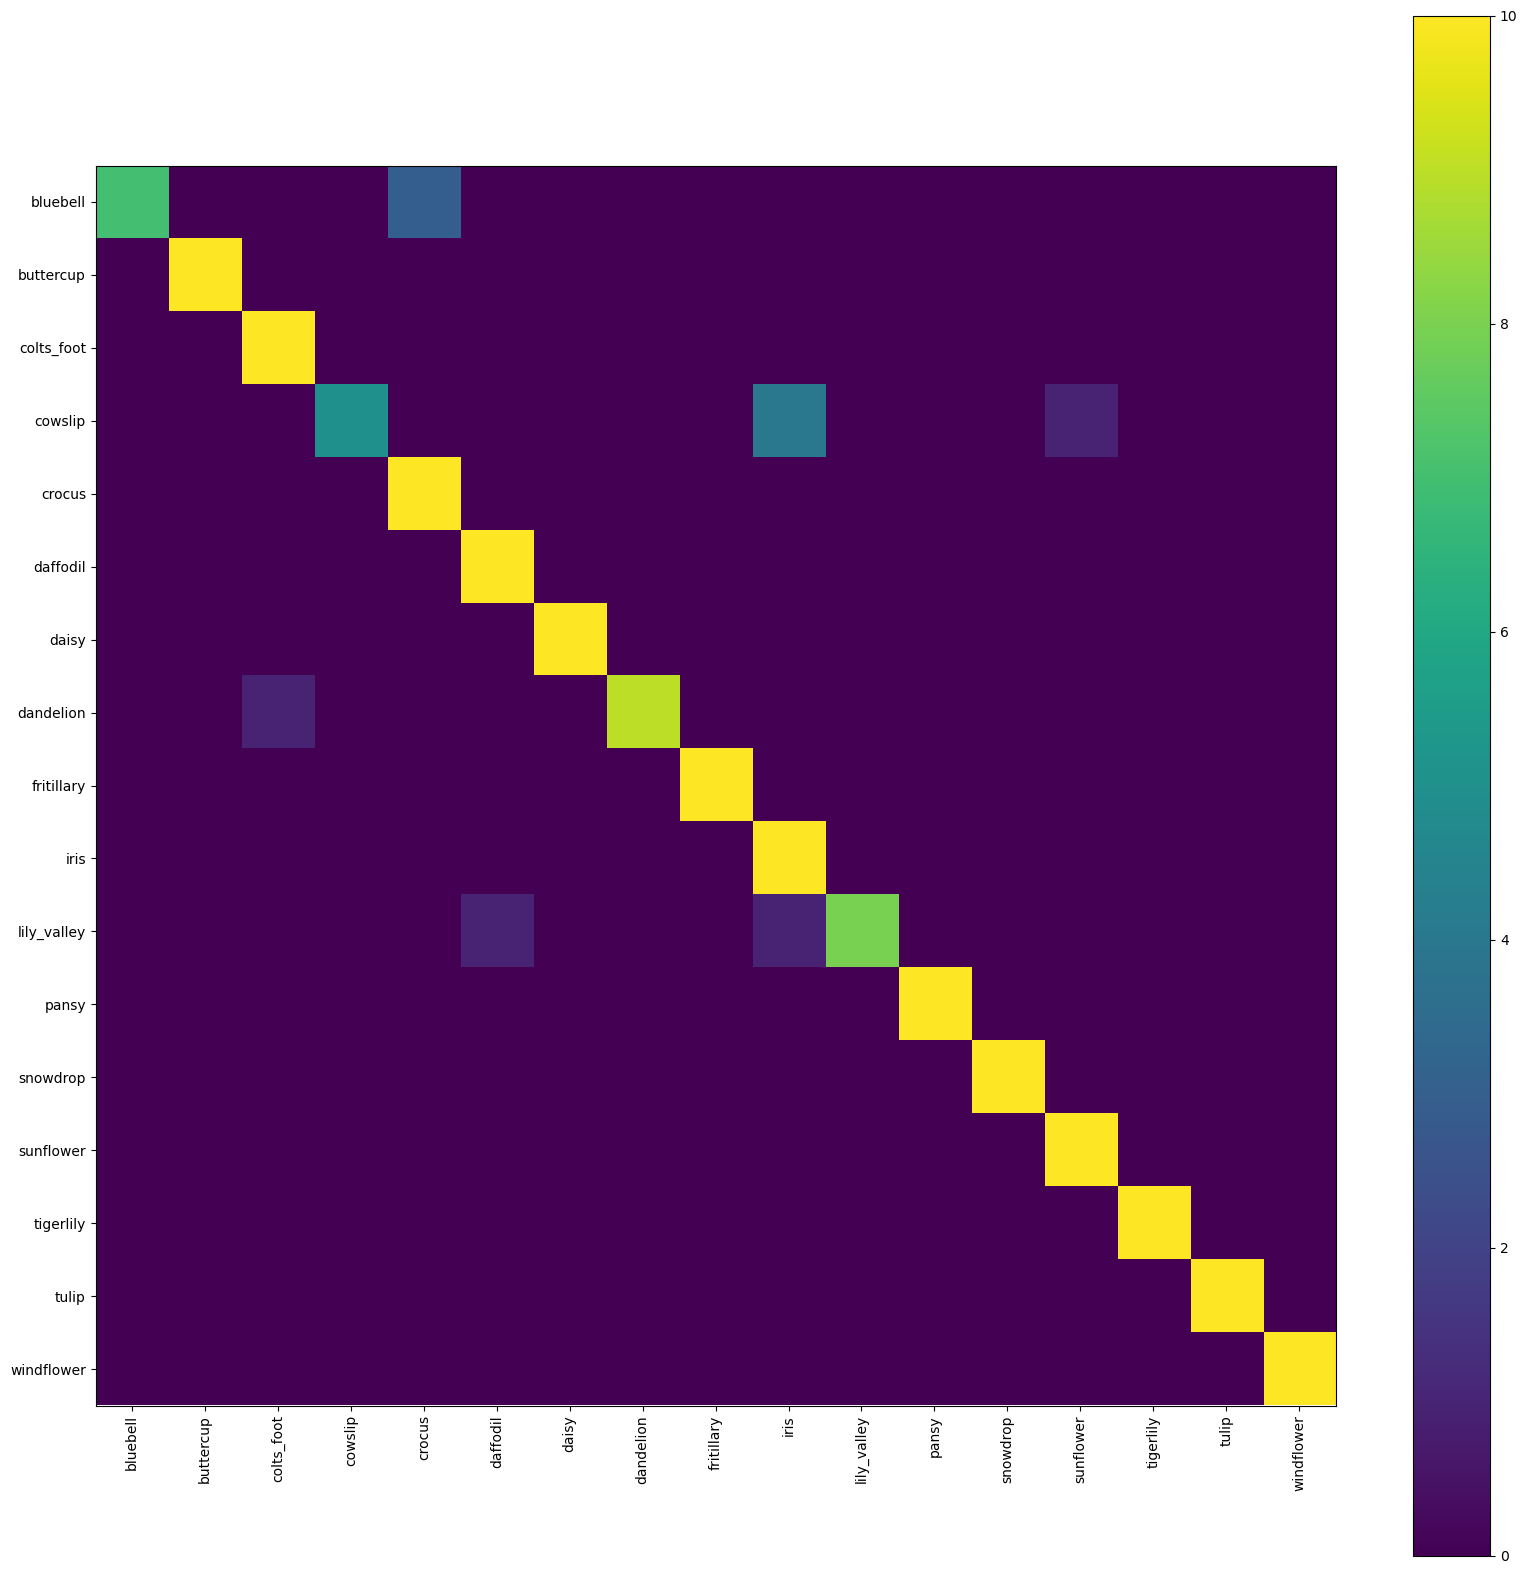

In [14]:
# Generate the confusion matrix for val dataset
cnf_matrix = confusion_matrix(y_true=val_generator.classes, y_pred=val_pred)

# Display the confusion matrix
plt.figure(figsize=(20, 20))
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(class_names))
_ = plt.xticks(tick_marks, class_names, rotation=90)
_ = plt.yticks(tick_marks, class_names)
plt.show()

# Classifier Demonstration

## Define Required Functions

In [15]:
# Define a function that grabs a random image from a random folder in the specified path
def get_random_image(path, img_width, img_height):
    folders = list(filter(lambda x: os.path.isdir(
        os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0, len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in os.listdir(
        file_path) if os.path.isfile(os.path.join(file_path, f))]
    random_file_index = np.random.randint(0, len(file_names))
    img_name = file_names[random_file_index]
    final_path = file_path + "/" + img_name
    img = Image.load_img(final_path, target_size=(img_width, img_height))
    return img, final_path, path_class


# Define a function that will draw class name, model's prediction & true label over the input image
def draw_test(name, pred, img, true_label):
    expanded_img = cv2.copyMakeBorder(
        img, 160, 0, 0, 500, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    cv2.putText(expanded_img, "predicted - " + pred, (20, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(expanded_img, "true - " + true_label, (20, 120),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow(name, expanded_img)

## Run the Demonstration

In [22]:
path = './Dataset/Validation/'
files = []
predictions = []
true_labels = []

for i in range(0, 10):
    img, final_path, true_label = get_random_image(path, 224, 224)
    files.append(final_path)
    true_labels.append(true_label)
    x = Image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = np.argmax(model.predict(x), axis=-1)
    predictions.append(classes)

for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Flower17 Classifier - Demo",
              class_names[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()